In [64]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [3]:
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    # import data
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [87]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

# 2016-2019 data
df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 5000) & (df1['usd_pledged'] > 100)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 5000) & (df1['usd_pledged'] > 100)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 5000)& (df1['usd_pledged'] > 100)]

df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')


In [88]:
### CREATORS WITH MULTIPLE CROWDFUNDING CAMPAIGNS

df2 = df1.copy()

# creators that have started more than one Kickstarter project
df2 = df2.loc[df2['creator_id'].isin(df2['creator_id'].value_counts()[df2['creator_id'].value_counts()>=2].index)]
# first sort by creator id, then sort by date
df2.sort_values(['creator_id', 'deadline'], ascending = [True, True], inplace = True)

creator_freq = df2['creator_id'].value_counts().to_dict()
print('Average number of rounds for creators with >1 project')
print(sum(creator_freq.values()) / len(creator_freq.values()))
df2_success_first = pd.DataFrame() # success first
df2_fail_first = pd.DataFrame() # fail first
for l in creator_freq:
    temp = df2.loc[df2['creator_id'] == l]
    if list(temp['state'])[0] == 'successful':
        df2_success_first = df2_success_first.append(temp)
    else:
        df2_fail_first = df2_fail_first.append(temp)

Average number of rounds for creators with >1 project
2.5113475177304965


In [89]:
category_num = dict()
for k, v in creator_freq.items():
    category_num[k] = df2.loc[df2['creator_id'] == k, 'category_name'].iloc[0]

new_dict = {}
for i in category_num.values():
    if i in new_dict.keys():
        new_dict[i] += 1
    else:
        new_dict[i] = 1

In [90]:
# write to csv file
df2.to_csv(path2 + "/Creators_All.csv", index = False) # 869
df2_success_first.to_csv(path2 + "/Creators_Success_First.csv", index = False) # 719
df2_fail_first.to_csv(path2 + "/Creators_Fail_First.csv", index = False) # 150

# 869 projects with creators who had multiple projects
# 719 of those had creators who were successful first
# 150 of those had creators who failed first

print('Total Number of Unique Creators: ' + str(len(df1['creator_id'].value_counts().to_dict())))
print('Total Number of Creators with > 1 Project: ' + str(len(df2['creator_id'].value_counts().to_dict())))
print('Total Number of Creators with = 1 Project: ' + str(len(df1['creator_id'].value_counts().to_dict()) - len(df2['creator_id'].value_counts().to_dict())))

Total Number of Unique Creators: 42202
Total Number of Creators with > 1 Project: 2820
Total Number of Creators with = 1 Project: 39382


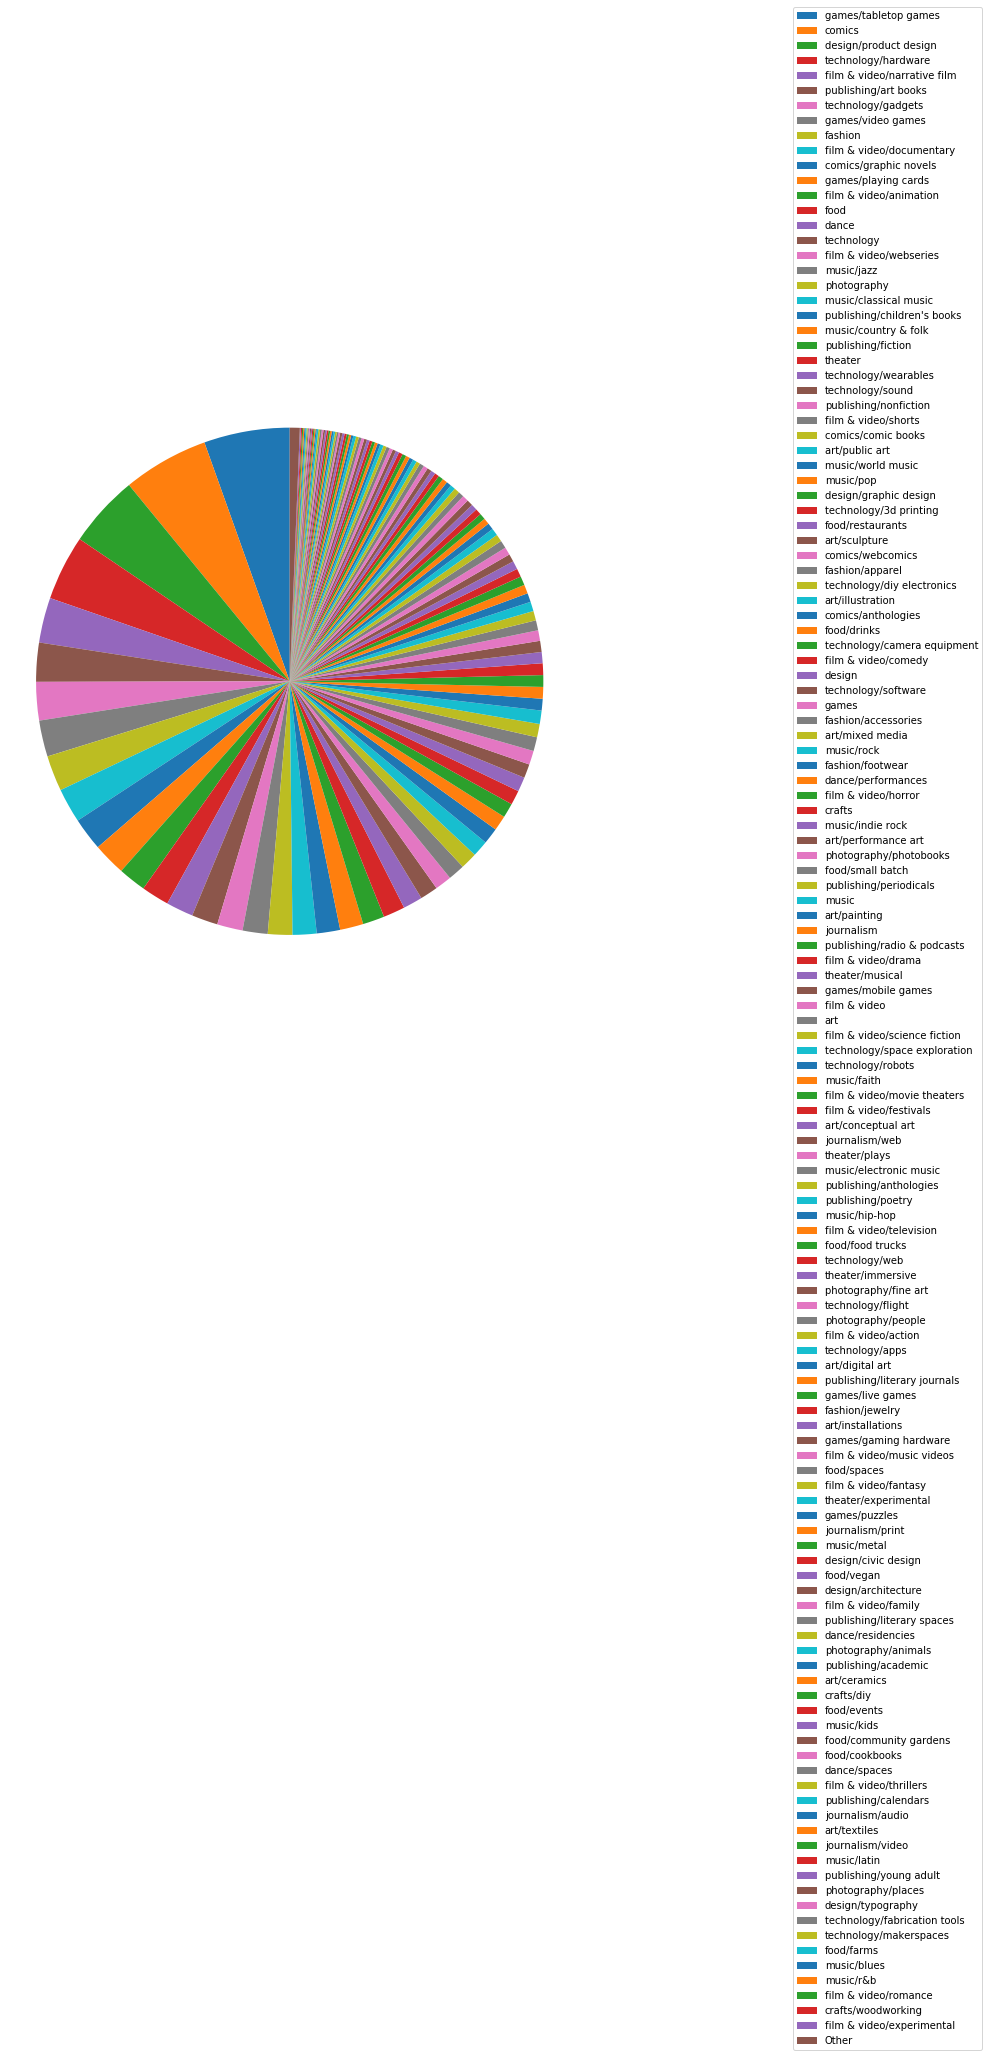

<Figure size 432x288 with 0 Axes>

In [211]:
sorted_x = sorted(new_dict.items(), key=lambda kv: kv[1], reverse = True)
od = collections.OrderedDict(sorted_x)
labels = list(od.keys())
all_num = list(od.values())

new_dict1 = {}
other = 0
for i in range(len(all_num)):
    if all_num[i] > 1: # more than 1 project
        new_dict1[labels[i]] = all_num[i]
    else:
        other += all_num[i]
new_dict1['Other'] = other

fig = plt.figure(figsize=(10, 10))
patches, texts = plt.pie(new_dict1.values(), startangle=90)
plt.legend(patches, new_dict1.keys(), loc="upper right", bbox_to_anchor=(1.75, 1.75))
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.savefig(path3 + 'Categories_subsequent_projects.png')

In [212]:
print(len(new_dict1.keys()))

136


In [92]:
### CALCULATION - PROBABILITY OF SUCCESS

# probability of success per category
category_multi_projects = []
category_success_rate = {}
category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()
# creating list of categories with more than one project
for i in category_freq:
    if category_freq[i] > 1:
        category_multi_projects.append(i)
for j in category_freq:
    if j in category_success_freq.keys():
        category_success_rate[j] = category_success_freq[j] / category_freq[j]
    else: # no successes in these categories
        category_success_rate[j] = 0
    
# probability of success for aggregate categories
success_rate = len(df1_success) / len(df1)
print("Probability of success:")
print(success_rate)

Probability of success:
0.6582730716253443


In [93]:
### CALCULATION - PROBABILITY OF SUCCESS

print('Considering all subsequent projects for a creator...')

category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()

# probability of success for creators conditional on first project successful per category
category_multi_projects_success_rate = {}
category_multi_projects_freq = df2['category_name'].value_counts().to_dict()
count_multi_projects_success = 0
for m in category_freq:
    if m in category_multi_projects_freq:
        temp = df2.loc[df2['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_multi_projects_success_rate[m] = curr_success / len(temp)
        count_multi_projects_success += curr_success
    else:
        category_multi_projects_success_rate[m] = 0

# probability of success for aggregate creators with multiple projects
multi_project_success_rate = count_multi_projects_success / len(df2)
print("Overall Probability of success conditional on multiple projects:")
print(multi_project_success_rate)

#-------------------

# probability of success for creators conditional on first project successful per category
# count all projects in a category whose creator began multiple projects with the first being successful
category_success_first_success_rate = {}
category_success_first_freq = df2_success_first['category_name'].value_counts().to_dict()
count_success_first_success = 0
for m in category_freq:
    if m in category_success_first_freq:
        temp = df2_success_first.loc[df2_success_first['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_success_first_success_rate[m] = curr_success / len(temp)
        count_success_first_success += curr_success
    else:
        category_success_first_success_rate[m] = 0

# probability of success for creators conditional on first project successful
success_first_success_rate = count_success_first_success / len(df2_success_first)
print("Overall Probability of success conditional on first project successful:")
print(success_first_success_rate)

#-------------------

# probability of success for creators conditional on first project failed per category
# all projects in a category whose creator began multiple projects with the first failing
category_fail_first_success_rate = {}
category_fail_first_freq = df2_fail_first['category_name'].value_counts().to_dict()
count_fail_first_success = 0
for n in category_freq:
    if n in category_fail_first_freq:
        temp = df2_fail_first.loc[df2_fail_first['category_name'] == n]
        curr_success = list(temp['state']).count('successful')
        category_fail_first_success_rate[n] = curr_success / len(temp)
        count_fail_first_success += curr_success
    else:
        category_fail_first_success_rate[n] = 0

# probability of success for creators conditional on first project failed
fail_first_success_rate = count_fail_first_success / len(df2_fail_first)
print("Overall Probability of success conditional on first project failed:")
print(fail_first_success_rate)

Considering all subsequent projects for a creator...
Overall Probability of success conditional on multiple projects:
0.8441118328155888
Overall Probability of success conditional on first project successful:
0.9543232765885724
Overall Probability of success conditional on first project failed:
0.2750217580504787


In [109]:
### CALCULATION PROB OF SUCCESS FOR 1ST SUBSEQUENT PROJECT

df2_2 = df1.copy()

df2_2 = df2_2.loc[df2_2['creator_id'].isin(df2_2['creator_id'].value_counts()[df2_2['creator_id'].value_counts() >= 2].index)]
# first sort by creator id, then sort by date
df2_2.sort_values(['creator_id', 'deadline'], ascending = [True, True], inplace = True)

creator_freq_2 = df2_2['creator_id'].value_counts().to_dict()

df2_2_success_first = pd.DataFrame() # success first
df2_2_fail_first = pd.DataFrame() # fail first
for l in creator_freq_2:
    temp = df2_2.loc[df2_2['creator_id'] == l]
    if list(temp['state'])[0] == 'successful':
        df2_2_success_first = df2_2_success_first.append(temp)
    else:
        df2_2_fail_first = df2_2_fail_first.append(temp)

creator_freq_2_success_first = df2_2_success_first['creator_id'].value_counts().to_dict()
creator_freq_2_fail_first = df2_2_fail_first['creator_id'].value_counts().to_dict()
        
        
print(len(creator_freq_2_success_first))
print(len(creator_freq_2_fail_first))
print()

# --------------------------------------------------------

df2_2_2 = pd.DataFrame() # only the 2nd project for the creators
for i in creator_freq_2:
    temp = df2_2.loc[df2_2['creator_id'] == i]
    df2_2_2 = df2_2_2.append(temp.iloc[[1]])
    
df2_2_2_success_first = pd.DataFrame() # only the 2nd project for the creators
for i in creator_freq_2_success_first:
    temp = df2_2_success_first.loc[df2_2_success_first['creator_id'] == i]
    df2_2_2_success_first = df2_2_2_success_first.append(temp.iloc[[1]])
    
df2_2_2_fail_first = pd.DataFrame() # only the 2nd project for the creators
for i in creator_freq_2_fail_first:
    temp = df2_2_fail_first.loc[df2_2_fail_first['creator_id'] == i]
    df2_2_2_fail_first = df2_2_2_fail_first.append(temp.iloc[[1]])

# --------------------------------------------------------

print('Considering all one subsequent projects for a creator...')

# probability of success for creators conditional on first project successful per category
category_multi_projects_2_success_rate = {}
category_multi_projects_2_freq = df2_2_2['category_name'].value_counts().to_dict()
count_multi_projects_2_success = 0
for m in category_freq:
    if m in category_multi_projects_2_freq:
        temp = df2_2_2.loc[df2_2_2['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_multi_projects_2_success_rate[m] = curr_success / len(temp)
        count_multi_projects_2_success += curr_success
    else:
        category_multi_projects_2_success_rate[m] = -1000000

# probability of success for aggregate creators with two projects
multi_project_2_success_rate = count_multi_projects_2_success / len(df2_2_2)
print("Probability of success conditional on two projects:")
print(multi_project_2_success_rate)

#-------------------

# probability of success for creators conditional on first project successful per category
category_success_first_2_success_rate = {}
category_success_first_2_freq = df2_2_2_success_first['category_name'].value_counts().to_dict()
count_success_first_2_success = 0
for m in category_freq:
    if m in category_success_first_2_freq:
        temp = df2_2_2_success_first.loc[df2_2_2_success_first['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_success_first_2_success_rate[m] = curr_success / len(temp)
        count_success_first_2_success += curr_success
    else:
        category_success_first_2_success_rate[m] = -1000000

# probability of success for creators conditional on first project successful
success_first_2_success_rate = count_success_first_2_success / len(df2_2_2_success_first)
print("Probability of success conditional on first project successful:")
print(success_first_2_success_rate)

#-------------------

# probability of success for creators conditional on first project failed per category
category_fail_first_2_success_rate = {}
category_fail_first_2_freq = df2_2_2_fail_first['category_name'].value_counts().to_dict() # per category, number of creators
count_fail_first_2_success = 0
for n in category_freq:
    if n in category_fail_first_2_freq:
        temp = df2_2_2_fail_first.loc[df2_2_2_fail_first['category_name'] == n]
        curr_success = list(temp['state']).count('successful')
        category_fail_first_2_success_rate[n] = curr_success / len(temp)
        count_fail_first_2_success += curr_success
    else:
        category_fail_first_2_success_rate[n] = -1000000

# probability of success for creators conditional on first project failed
fail_first_2_success_rate = count_fail_first_2_success / len(df2_2_2_fail_first)
print("Probability of success conditional on first project failed:")
print(fail_first_2_success_rate)

2299
521

Considering all one subsequent projects for a creator...
Probability of success conditional on two projects:
0.8301418439716312
Probability of success conditional on first project successful:
0.9099608525445846
Probability of success conditional on first project failed:
0.4779270633397313


In [205]:
### CALCULATION PROB OF SUCCESS FOR 2ND SUBSEQUENT PROJECT

df2_3 = df1.copy()

df2_3 = df2_3.loc[df2_3['creator_id'].isin(df2_3['creator_id'].value_counts()[df2_3['creator_id'].value_counts() >= 3].index)]
# first sort by creator id, then sort by date
df2_3.sort_values(['creator_id', 'deadline'], ascending = [True, True], inplace = True)

creator_freq_3 = df2_3['creator_id'].value_counts().to_dict()

df2_3_ss = pd.DataFrame()
df2_3_sf = pd.DataFrame()
df2_3_fs = pd.DataFrame()
df2_3_ff = pd.DataFrame()
for l in creator_freq_3:
    temp = df2_3.loc[df2_3['creator_id'] == l]
    if list(temp['state'])[0] == 'successful':
        if list(temp['state'])[1] == 'successful':
            df2_3_ss = df2_3_ss.append(temp)
        else:
            df2_3_sf = df2_3_sf.append(temp)
    else:
        if list(temp['state'])[1] == 'successful':
            df2_3_fs = df2_3_fs.append(temp)
        else:
            df2_3_ff = df2_3_ff.append(temp)

creator_freq_3_ss = df2_3_ss['creator_id'].value_counts().to_dict()
creator_freq_3_sf = df2_3_sf['creator_id'].value_counts().to_dict()
creator_freq_3_fs = df2_3_fs['creator_id'].value_counts().to_dict()
creator_freq_3_ff = df2_3_ff['creator_id'].value_counts().to_dict()


# --------------------------------------------------------

df2_3_1 = pd.DataFrame()
df2_3_2 = pd.DataFrame()
df2_3_3 = pd.DataFrame()
for i in creator_freq_3:
    temp = df2_3.loc[df2_3['creator_id'] == i]
    df2_3_1 = df2_3_1.append(temp.iloc[[0]])
    df2_3_2 = df2_3_2.append(temp.iloc[[1]])
    df2_3_3 = df2_3_3.append(temp.iloc[[2]])
    
df2_3_1_ss = pd.DataFrame()
df2_3_2_ss = pd.DataFrame()
df2_3_3_ss = pd.DataFrame()
for i in creator_freq_3_ss:
    temp = df2_3_ss.loc[df2_3_ss['creator_id'] == i]
    df2_3_1_ss = df2_3_1_ss.append(temp.iloc[[0]])
    df2_3_2_ss = df2_3_2_ss.append(temp.iloc[[1]])
    df2_3_3_ss = df2_3_3_ss.append(temp.iloc[[2]])
    
df2_3_1_sf = pd.DataFrame()
df2_3_2_sf = pd.DataFrame()
df2_3_3_sf = pd.DataFrame()
for i in creator_freq_3_sf:
    temp = df2_3_sf.loc[df2_3_sf['creator_id'] == i]
    df2_3_1_sf = df2_3_1_sf.append(temp.iloc[[0]])
    df2_3_2_sf = df2_3_2_sf.append(temp.iloc[[1]])
    df2_3_3_sf = df2_3_3_sf.append(temp.iloc[[2]])
    
df2_3_1_fs = pd.DataFrame()
df2_3_2_fs = pd.DataFrame()
df2_3_3_fs = pd.DataFrame()
for i in creator_freq_3_fs:
    temp = df2_3_fs.loc[df2_3_fs['creator_id'] == i]
    df2_3_1_fs = df2_3_1_fs.append(temp.iloc[[0]])
    df2_3_2_fs = df2_3_2_fs.append(temp.iloc[[1]])
    df2_3_3_fs = df2_3_3_fs.append(temp.iloc[[2]])
    
df2_3_1_ff = pd.DataFrame()
df2_3_2_ff = pd.DataFrame()
df2_3_3_ff = pd.DataFrame()
for i in creator_freq_3_ff:
    temp = df2_3_ff.loc[df2_3_ff['creator_id'] == i]
    df2_3_1_ff = df2_3_1_ff.append(temp.iloc[[0]])
    df2_3_2_ff = df2_3_2_ff.append(temp.iloc[[1]])
    df2_3_3_ff = df2_3_3_ff.append(temp.iloc[[2]])

# # --------------------------------------------------------

print('Considering all one subsequent projects for a creator...')

# probability of success for creators conditional on first project successful per category
category_multi_projects_3_success_rate = {}
category_multi_projects_3_freq = df2_3_3['category_name'].value_counts().to_dict()
count_multi_projects_3_success = 0
for m in category_freq:
    if m in category_multi_projects_3_freq:
        temp = df2_3_3.loc[df2_3_3['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_multi_projects_3_success_rate[m] = curr_success / len(temp)
        count_multi_projects_3_success += curr_success
    else:
        category_multi_projects_3_success_rate[m] = -1000000

# probability of success for aggregate creators with two projects
multi_project_3_success_rate = count_multi_projects_3_success / len(df2_3_3)
print("Probability of success conditional on three projects:")
print(multi_project_3_success_rate)

# #-------------------

# probability of success for creators conditional on first two project successful per category
category_ss_3_success_rate = {}
category_ss_3_freq = df2_3_3_ss['category_name'].value_counts().to_dict()
count_ss_3_success = 0
for m in category_freq:
    if m in category_ss_3_freq:
        temp = df2_3_3_ss.loc[df2_3_3_ss['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_ss_3_success_rate[m] = curr_success / len(temp)
        count_ss_3_success += curr_success
    else:
        category_ss_3_success_rate[m] = -1000000

# probability of success for creators conditional on ss
ss_3_success_rate = count_ss_3_success / len(df2_3_3_ss)
print("Probability of success conditional on two project successful:")
print(ss_3_success_rate)

# probability of success for creators conditional on project successful, failed per category
category_sf_3_success_rate = {}
category_sf_3_freq = df2_3_3_sf['category_name'].value_counts().to_dict()
count_sf_3_success = 0
for m in category_freq:
    if m in category_sf_3_freq:
        temp = df2_3_3_sf.loc[df2_3_3_sf['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_sf_3_success_rate[m] = curr_success / len(temp)
        count_sf_3_success += curr_success
    else:
        category_sf_3_success_rate[m] = -1000000

# probability of success for creators conditional on sf
sf_3_success_rate = count_sf_3_success / len(df2_3_3_sf)
print("Probability of success conditional on project successful, failed:")
print(sf_3_success_rate)

# probability of success for creators conditional on project failed, successful per category
category_fs_3_success_rate = {}
category_fs_3_freq = df2_3_3_fs['category_name'].value_counts().to_dict()
count_fs_3_success = 0
for m in category_freq:
    if m in category_fs_3_freq:
        temp = df2_3_3_fs.loc[df2_3_3_fs['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_fs_3_success_rate[m] = curr_success / len(temp)
        count_fs_3_success += curr_success
    else:
        category_fs_3_success_rate[m] = -1000000

# probability of success for creators conditional on fs
fs_3_success_rate = count_fs_3_success / len(df2_3_3_fs)
print("Probability of success conditional on project failed, successful:")
print(fs_3_success_rate)

# probability of success for creators conditional on two project failed per category
category_ff_3_success_rate = {}
category_ff_3_freq = df2_3_3_ff['category_name'].value_counts().to_dict()
count_ff_3_success = 0
for m in category_freq:
    if m in category_ff_3_freq:
        temp = df2_3_3_ff.loc[df2_3_3_ff['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_ff_3_success_rate[m] = curr_success / len(temp)
        count_ff_3_success += curr_success
    else:
        category_ff_3_success_rate[m] = -1000000

# probability of success for creators conditional on ff
ff_3_success_rate = count_ff_3_success / len(df2_3_3_ff)
print("Probability of success conditional on two project failed:")
print(ff_3_success_rate)

Considering all one subsequent projects for a creator...
Probability of success conditional on three projects:
0.9110473457675753
Probability of success conditional on two project successful:
0.9593908629441624
Probability of success conditional on project successful, failed:
0.75
Probability of success conditional on project failed, successful:
0.7073170731707317
Probability of success conditional on two project failed:
0.36


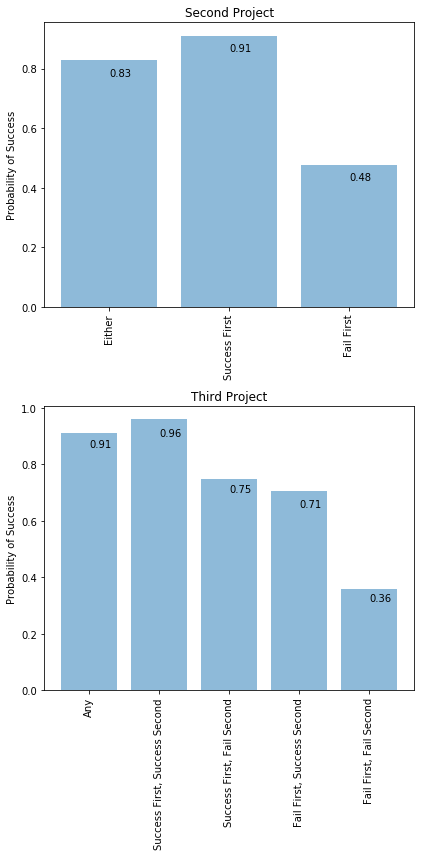

In [219]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

fig = plt.figure(figsize=(6, 12))

plt.subplot(2, 1, 1)
objects = ('Either', 'Success First', 'Fail First')
y_pos = np.arange(len(objects))
performance = [multi_project_2_success_rate, success_first_2_success_rate, fail_first_2_success_rate]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Probability of Success')
plt.text(x = 0 , y = 0.775, s = round(performance[0], 2), size = 10)
plt.text(x = 1 , y = 0.86, s = round(performance[1], 2), size = 10)
plt.text(x = 2 , y = 0.425, s = round(performance[2], 2), size = 10)
plt.title('Second Project')

plt.subplot(2, 1, 2)
objects = ('Any', 'Success First, Success Second', 'Success First, Fail Second', 'Fail First, Success Second', 'Fail First, Fail Second')
y_pos = np.arange(len(objects))
performance = [multi_project_3_success_rate, ss_3_success_rate, sf_3_success_rate, fs_3_success_rate, ff_3_success_rate]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Probability of Success')
plt.text(x = 0 , y = 0.86, s = round(performance[0], 2), size = 10)
plt.text(x = 1 , y = 0.9, s = round(performance[1], 2), size = 10)
plt.text(x = 2 , y = 0.7, s = round(performance[2], 2), size = 10)
plt.text(x = 3 , y = 0.65, s = round(performance[3], 2), size = 10)
plt.text(x = 4 , y = 0.315, s = round(performance[4], 2), size = 10)
plt.title('Third Project')

plt.tight_layout()

plt.savefig(path3 + 'Prob_success_subsequent_projects.png')

In [111]:
# write to csv
subsets = [category_success_rate, \
           category_multi_projects_success_rate, \
           category_success_first_success_rate, \
           category_fail_first_success_rate, \
           category_multi_projects_2_success_rate, \
           category_success_first_2_success_rate, \
           category_fail_first_2_success_rate]
prob_success = {}
for k in category_success_rate.keys():
    prob_success[k] = list(str(prob_success[k]) for prob_success in subsets)
    
df8 = pd.DataFrame(prob_success.items(), columns = ['category_name', 'prob_of_success'])
count1 = 0
count2 = 0
with open(path2 + "/Prob_Of_Success_Creator.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Multiple','Multiple|Success','Multiple|Fail','Success First > Fail First','Success|Either','Success|Success','Success|Fail','Success First > Fail First'])
    for i in range(len(df8['prob_of_success'])):
        lst = list(df8['prob_of_success'])[i]
        lst1 = [ '%.4f' % float(j) for j in lst]
        if lst1[2] not in ['1.0000','1','0.0000','0'] or lst1[3] not in ['1.0000','1','0.0000','0']:
            lst2 = list(category_freq)
            lst1.insert(0, str(lst2[i]))
            diff1 = round(float(lst1[3]) - float(lst1[4]),4)
            lst1.insert(5, diff1)
            diff2 = round(float(lst1[7]) - float(lst1[8]),4)
            if diff2 > 0 and abs(diff2) <= 1:
                count1 += 1
            elif diff2 < 0 and abs(diff2) <= 1:
                count2 += 1
            lst1.insert(9, diff2)
            writer.writerow(lst1)

print("Prob of success for next project given success > given fail for the following percentage of categories: ")
print("{:.2%}".format(count1 / (count1 + count2)))
            
            

Prob of success for next project given success > given fail for the following percentage of categories: 
80.52%


In [97]:
### CALCULATION - NUMBER OF PROJECTS

category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()
project_num = dict()

#-------------------

# multiple
for k, v in category_freq.items():
    if k in category_multi_projects_freq.keys():
        project_num[k] = [category_multi_projects_freq[k]]
    else: 
        project_num[k] = [0]
        
#------------------- 

# number creators --> success|either
for k, v in category_freq.items():
    if k in category_multi_projects_2_freq.keys():
        project_num[k].append(category_multi_projects_2_freq[k])
    else:
        project_num[k].append(0)

# number creators --> success|success
for k, v in category_freq.items():
    if k in category_success_first_2_freq.keys():
        project_num[k].append(category_success_first_2_freq[k])
    else:
        project_num[k].append(0)
        
# number creators --> success|fail
for k, v in category_freq.items():
    if k in category_fail_first_2_freq.keys():
        project_num[k].append(category_fail_first_2_freq[k])
    else: 
        project_num[k].append(0)

# ------------------
        
# Write calculations to csv files

df7 = pd.DataFrame(project_num.items(), columns = ['category_name', 'number'])
with open(path2 + "/Number_Creator.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','Multiple','Success|Either','Success|Success','Success|Fail'])
    for i in range(len(df7['number'])):
        lst1 = list(df7['number'])[i]
        if lst1[0] not in [1.0,1,0.0,0]:
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

In [98]:
### CALCULATION - PROPORTION

project_proportion = dict()

# multiple
for k, v in category_freq.items():
    if k in category_multi_projects_freq.keys():
        project_proportion[k] = [category_multi_projects_freq[k] / len(df2)]
    else:
        project_proportion[k] = [0]
        
#------------------- 
        
# proportion creators --> success|either
for k, v in category_freq.items():
    if k in category_multi_projects_2_freq.keys():
        project_proportion[k].append(category_multi_projects_2_freq[k] / len(df2_2_2))
    else:
        project_proportion[k].append(0)
    
# proportion creators --> success|success
for k, v in category_freq.items():
    if k in category_success_first_2_freq.keys():
        project_proportion[k].append(category_success_first_2_freq[k] / len(df2_2_2_success_first))
    else:
        project_proportion[k].append(0)
        
# proportion creators --> success|fail
for k, v in category_freq.items():
    if k in category_fail_first_2_freq.keys():
        project_proportion[k].append(category_fail_first_2_freq[k] / len(df2_2_2_fail_first))
    else:
        project_proportion[k].append(0)

# ------------------
        
# Write calculations to csv files

df9 = pd.DataFrame(project_proportion.items(), columns = ['category_name', 'number'])
with open(path2 + "/Proportion_Creator.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','Multiple','Success|Either','Success|Success','Success|Fail'])
    for i in range(len(df9['number'])):
        lst1 = list(df9['number'])[i]
        if lst1[0] not in [1.0,1,0.0,0]:
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

In [169]:
### GOAL / PLEDGED SIZE

print('Considering all first projects:')

category_multi_projects_1_goal = {}
category_multi_projects_1_pledged = {}
category_multi_projects_1_goal1 = {}
category_multi_projects_1_pledged1 = {}
category_multi_projects_1_freq = df2_2_1['category_name'].value_counts().to_dict()
for m in category_freq:
    temp = df2_2_1.loc[df2_2_1['category_name'] == m]
    if list(temp['goal']) != []:
        category_multi_projects_1_goal[m] = sum(list(temp['goal'])) / len(temp['goal'])
        category_multi_projects_1_goal1[m] = statistics.median(list(temp['goal']))
    if list(temp['usd_pledged']) != []:
        category_multi_projects_1_pledged[m] = sum(list(temp['usd_pledged'])) / len(temp['usd_pledged'])
        category_multi_projects_1_pledged1[m] = statistics.median(list(temp['usd_pledged']))

multi_project_1_goal = sum(list(df2_2_1['goal'])) / len(list(df2_2_1['goal']))
multi_project_1_goal1 = statistics.median(list(df2_2_1['goal']))
multi_project_1_pledged = sum(list(df2_2_1['usd_pledged'])) / len(list(df2_2_1['usd_pledged']))
multi_project_1_pledged1 = statistics.median(list(df2_2_1['usd_pledged']))
print("Average goal size of 1st project: ")
print(multi_project_1_goal)
print("Median goal size of 1st project: ")
print(multi_project_1_goal1)
print("Average pledge size of 1st project: ")
print(multi_project_1_pledged)
print("Median pledge size of 1st project: ")
print(multi_project_1_pledged1)


category_multi_projects_2_goal = {}
category_multi_projects_2_pledged = {}
category_multi_projects_2_goal1 = {}
category_multi_projects_2_pledged1 = {}
category_multi_projects_2_freq = df2_2_2['category_name'].value_counts().to_dict()
for m in category_freq:
    temp = df2_2_2.loc[df2_2_2['category_name'] == m]
    if list(temp['goal']) != []:
        category_multi_projects_2_goal[m] = sum(list(temp['goal'])) / len(temp['goal'])
        category_multi_projects_2_goal1[m] = statistics.median(list(temp['goal']))
    if list(temp['usd_pledged']) != []:
        category_multi_projects_2_pledged[m] = sum(list(temp['usd_pledged'])) / len(temp['usd_pledged'])
        category_multi_projects_2_pledged1[m] = statistics.median(list(temp['usd_pledged']))

multi_project_2_goal = sum(list(df2_2_2['goal'])) / len(list(df2_2_2['goal']))
multi_project_2_goal1 = statistics.median(list(df2_2_2['goal']))
multi_project_2_pledged = sum(list(df2_2_2['usd_pledged'])) / len(list(df2_2_2['usd_pledged']))
multi_project_2_pledged1 = statistics.median(list(df2_2_2['usd_pledged']))
print()
print("Average goal size of 2nd project: ")
print(multi_project_2_goal)
print("Median goal size of 2nd project: ")
print(multi_project_2_goal1)
print("Average pledge size of 2nd project: ")
print(multi_project_2_pledged)
print("Median pledge size of 2nd project: ")
print(multi_project_2_pledged1)

multi_project_3_goal = sum(list(df2_3_3['goal'])) / len(list(df2_3_3['goal']))
multi_project_3_goal1 = statistics.median(list(df2_3_3['goal']))
multi_project_3_pledged = sum(list(df2_3_3['usd_pledged'])) / len(list(df2_3_3['usd_pledged']))
multi_project_3_pledged1 = statistics.median(list(df2_3_3['usd_pledged']))
print()
print("Average goal size of 3rd project: ")
print(multi_project_3_goal)
print("Median goal size of 3rd project: ")
print(multi_project_3_goal1)
print("Average pledge size of 3rd project: ")
print(multi_project_3_pledged)
print("Median pledge size of 3rd project: ")
print(multi_project_3_pledged1)
#-------------------

category_success_first_1_goal = {}
category_success_first_1_pledged = {}
category_success_first_1_goal1 = {}
category_success_first_1_pledged1 = {}
category_success_first_1_freq = df2_2_1_success_first['category_name'].value_counts().to_dict()
for m in category_freq:
    temp = df2_2_1_success_first.loc[df2_2_1_success_first['category_name'] == m]
    if list(temp['goal']) != []:
        category_success_first_1_goal[m] = sum(list(temp['goal'])) / len(temp['goal'])
        category_success_first_1_goal1[m] = statistics.median(list(temp['goal']))
    if list(temp['usd_pledged']) != []:
        category_success_first_1_pledged[m] = sum(list(temp['usd_pledged'])) / len(temp['usd_pledged'])
        category_success_first_1_pledged1[m] = statistics.median(list(temp['usd_pledged']))

success_first_1_goal = sum(list(df2_2_1_success_first['goal'])) / len(list(df2_2_1_success_first['goal']))
success_first_1_goal1 = statistics.median(list(df2_2_1_success_first['goal']))
success_first_1_pledged = sum(list(df2_2_1_success_first['usd_pledged'])) / len(list(df2_2_1_success_first['usd_pledged']))
success_first_1_pledged1 = statistics.median(list(df2_2_1_success_first['usd_pledged']))
print()
print('Conditional on first project successful:')
print("Average goal size of 1st project: ")
print(success_first_1_goal)
print("Median goal size of 1st project: ")
print(success_first_1_goal1)
print("Average pledge size of 1st project: ")
print(success_first_1_pledged)
print("Median pledge size of 1st project: ")
print(success_first_1_pledged1)

category_success_first_2_goal = {}
category_success_first_2_pledged = {}
category_success_first_2_goal1 = {}
category_success_first_2_pledged1 = {}
category_success_first_2_freq = df2_2_2_success_first['category_name'].value_counts().to_dict()
for m in category_freq:
    temp = df2_2_2_success_first.loc[df2_2_2_success_first['category_name'] == m]
    if list(temp['goal']) != []:
        category_success_first_2_goal[m] = sum(list(temp['goal'])) / len(temp['goal'])
        category_success_first_2_goal1[m] = statistics.median(list(temp['goal']))
    if list(temp['usd_pledged']) != []:
        category_success_first_2_pledged[m] = sum(list(temp['usd_pledged'])) / len(temp['usd_pledged'])
        category_success_first_2_pledged1[m] = statistics.median(list(temp['usd_pledged']))

success_first_2_goal = sum(list(df2_2_2_success_first['goal'])) / len(list(df2_2_2_success_first['goal']))
success_first_2_goal1 = statistics.median(list(df2_2_2_success_first['goal']))
success_first_2_pledged = sum(list(df2_2_2_success_first['usd_pledged'])) / len(list(df2_2_2_success_first['usd_pledged']))
success_first_2_pledged1 = statistics.median(list(df2_2_2_success_first['usd_pledged']))
print()
print("Average goal size of 2nd project: ")
print(success_first_2_goal)
print("Median goal size of 2nd project: ")
print(success_first_2_goal1)
print("Average pledge size of 2nd project: ")
print(success_first_2_pledged)
print("Median pledge size of 2nd project: ")
print(success_first_2_pledged1)

ss_3_goal = sum(list(df2_3_3_ss['goal'])) / len(list(df2_3_3_ss['goal']))
ss_3_goal1 = statistics.median(list(df2_3_3_ss['goal']))
ss_3_pledged = sum(list(df2_3_3_ss['usd_pledged'])) / len(list(df2_3_3_ss['usd_pledged']))
ss_3_pledged1 = statistics.median(list(df2_3_3_ss['usd_pledged']))
print()
print('Conditional on second project successful:')
print("Average goal size of 3rd project: ")
print(ss_3_goal)
print("Median goal size of 3rd project: ")
print(ss_3_goal1)
print("Average pledge size of 3rd project: ")
print(ss_3_pledged)
print("Median pledge size of 3rd project: ")
print(ss_3_pledged1)

sf_3_goal = sum(list(df2_3_3_sf['goal'])) / len(list(df2_3_3_sf['goal']))
sf_3_goal1 = statistics.median(list(df2_3_3_sf['goal']))
sf_3_pledged = sum(list(df2_3_3_sf['usd_pledged'])) / len(list(df2_3_3_sf['usd_pledged']))
sf_3_pledged1 = statistics.median(list(df2_3_3_sf['usd_pledged']))
print()
print('Conditional on second project failed:')
print("Average goal size of 3rd project: ")
print(sf_3_goal)
print("Median goal size of 3rd project: ")
print(sf_3_goal1)
print("Average pledge size of 3rd project: ")
print(sf_3_pledged)
print("Median pledge size of 3rd project: ")
print(sf_3_pledged1)

#-------------------

category_fail_first_1_goal = {}
category_fail_first_1_pledged = {}
category_fail_first_1_goal1 = {}
category_fail_first_1_pledged1 = {}
category_fail_first_1_freq = df2_2_1_fail_first['category_name'].value_counts().to_dict()
for m in category_freq:
    temp = df2_2_1_fail_first.loc[df2_2_1_fail_first['category_name'] == m]
    if list(temp['goal']) != []:
        category_fail_first_1_goal[m] = sum(list(temp['goal'])) / len(temp['goal'])
        category_fail_first_1_goal1[m] = statistics.median(list(temp['goal']))
    if list(temp['usd_pledged']) != []:
        category_fail_first_1_pledged[m] = sum(list(temp['usd_pledged'])) / len(temp['usd_pledged'])
        category_fail_first_1_pledged1[m] = statistics.median(list(temp['usd_pledged']))

fail_first_1_goal = sum(list(df2_2_1_fail_first['goal'])) / len(list(df2_2_1_fail_first['goal']))
fail_first_1_goal1 = statistics.median(list(df2_2_1_fail_first['goal']))
fail_first_1_pledged = sum(list(df2_2_1_fail_first['usd_pledged'])) / len(list(df2_2_1_fail_first['usd_pledged']))
fail_first_1_pledged1 = statistics.median(list(df2_2_1_fail_first['usd_pledged']))
print()
print('Conditional on first project failed:')
print("Average goal size of 1st project: ")
print(fail_first_1_goal)
print("Median goal size of 1st project: ")
print(fail_first_1_goal1)
print("Average pledge size of 1st project: ")
print(fail_first_1_pledged)
print("Median pledge size of 1st project: ")
print(fail_first_1_pledged1)

category_fail_first_2_goal = {}
category_fail_first_2_pledged = {}
category_fail_first_2_goal1 = {}
category_fail_first_2_pledged1 = {}
category_fail_first_2_freq = df2_2_2_fail_first['category_name'].value_counts().to_dict()
for m in category_freq:
    temp = df2_2_2_fail_first.loc[df2_2_2_fail_first['category_name'] == m]
    if list(temp['goal']) != []:
        category_fail_first_2_goal[m] = sum(list(temp['goal'])) / len(temp['goal'])
        category_fail_first_2_goal1[m] = statistics.median(list(temp['goal']))
    if list(temp['usd_pledged']) != []:
        category_fail_first_2_pledged[m] = sum(list(temp['usd_pledged'])) / len(temp['usd_pledged'])
        category_fail_first_2_pledged1[m] = statistics.median(list(temp['usd_pledged']))
        
fail_first_2_goal = sum(list(df2_2_2_fail_first['goal'])) / len(list(df2_2_2_fail_first['goal']))
fail_first_2_goal1 = statistics.median(list(df2_2_2_fail_first['goal']))
fail_first_2_pledged = sum(list(df2_2_2_fail_first['usd_pledged'])) / len(list(df2_2_2_fail_first['usd_pledged']))
fail_first_2_pledged1 = statistics.median(list(df2_2_2_fail_first['usd_pledged']))
print()
print("Average goal size of 2nd project: ")
print(fail_first_2_goal)
print("Median goal size of 2nd project: ")
print(fail_first_2_goal1)
print("Average pledge size of 2nd project: ")
print(fail_first_2_pledged)
print("Median pledge size of 2nd project: ")
print(fail_first_2_pledged1)

fs_3_goal = sum(list(df2_3_3_fs['goal'])) / len(list(df2_3_3_fs['goal']))
fs_3_goal1 = statistics.median(list(df2_3_3_fs['goal']))
fs_3_pledged = sum(list(df2_3_3_fs['usd_pledged'])) / len(list(df2_3_3_fs['usd_pledged']))
fs_3_pledged1 = statistics.median(list(df2_3_3_fs['usd_pledged']))
print()
print('Conditional on second project successful:')
print("Average goal size of 3rd project: ")
print(fs_3_goal)
print("Median goal size of 3rd project: ")
print(fs_3_goal1)
print("Average pledge size of 3rd project: ")
print(fs_3_pledged)
print("Median pledge size of 3rd project: ")
print(fs_3_pledged1)

ff_3_goal = sum(list(df2_3_3_ff['goal'])) / len(list(df2_3_3_ff['goal']))
ff_3_goal1 = statistics.median(list(df2_3_3_ff['goal']))
ff_3_pledged = sum(list(df2_3_3_ff['usd_pledged'])) / len(list(df2_3_3_ff['usd_pledged']))
ff_3_pledged1 = statistics.median(list(df2_3_3_ff['usd_pledged']))
print()
print('Conditional on second project failed:')
print("Average goal size of 3rd project: ")
print(ff_3_goal)
print("Median goal size of 3rd project: ")
print(ff_3_goal1)
print("Average pledge size of 3rd project: ")
print(ff_3_pledged)
print("Median pledge size of 3rd project: ")
print(ff_3_pledged1)

Considering all first projects:
Average goal size of 1st project: 
83297.0731707317
Median goal size of 1st project: 
50000.0
Average pledge size of 1st project: 
268116.3798954703
Median pledge size of 1st project: 
102410.0

Average goal size of 2nd project: 
30264.509209219857
Median goal size of 2nd project: 
15000.0
Average pledge size of 2nd project: 
57900.10038652482
Median pledge size of 2nd project: 
17252.0

Average goal size of 3rd project: 
29094.813486370156
Median goal size of 3rd project: 
15000.0
Average pledge size of 3rd project: 
68028.810215208
Median pledge size of 3rd project: 
23165.0

Conditional on first project successful:
Average goal size of 1st project: 
74994.70925110132
Median goal size of 1st project: 
50000.0
Average pledge size of 1st project: 
330181.78176211455
Median pledge size of 1st project: 
134236.22

Average goal size of 2nd project: 
31411.374497607656
Median goal size of 2nd project: 
15000.0
Average pledge size of 2nd project: 
65113.36725

In [170]:
### BACKERS

print('Considering all first projects:')


multi_project_1_backers = sum(list(df2_2_1['backers_count'])) / len(list(df2_2_1['backers_count']))
multi_project_1_backers1 = statistics.median(list(df2_2_1['backers_count']))

print("Average backers of 1st project: ")
print(multi_project_1_backers)
print("Median backers of 1st project: ")
print(multi_project_1_backers1)

multi_project_2_backers = sum(list(df2_2_2['backers_count'])) / len(list(df2_2_2['backers_count']))
multi_project_2_backers1 = statistics.median(list(df2_2_2['backers_count']))

print()
print("Average backers of 2nd project: ")
print(multi_project_2_backers)
print("Median backers of 2nd project: ")
print(multi_project_2_backers1)

multi_project_3_backers = sum(list(df2_3_3['backers_count'])) / len(list(df2_3_3['backers_count']))
multi_project_3_backers1 = statistics.median(list(df2_3_3['backers_count']))

print()
print("Average backers of 3rd project: ")
print(multi_project_3_backers)
print("Median backers of 3rd project: ")
print(multi_project_3_backers1)

#-------------------

success_first_1_backers = sum(list(df2_2_1_success_first['backers_count'])) / len(list(df2_2_1_success_first['backers_count']))
success_first_1_backers1 = statistics.median(list(df2_2_1_success_first['backers_count']))

print()
print('Conditional on first project successful:')
print("Average backers of 1st project: ")
print(success_first_1_backers)
print("Median backers of 1st project: ")
print(success_first_1_backers1)

success_first_2_backers = sum(list(df2_2_2_success_first['backers_count'])) / len(list(df2_2_2_success_first['backers_count']))
success_first_2_backers1 = statistics.median(list(df2_2_2_success_first['backers_count']))

print()
print("Average backers of 2nd project: ")
print(success_first_2_backers)
print("Median backers of 2nd project: ")
print(success_first_2_backers1)

ss_3_backers = sum(list(df2_3_3_ss['backers_count'])) / len(list(df2_3_3_ss['backers_count']))
ss_3_backers1 = statistics.median(list(df2_3_3_ss['backers_count']))

print()
print('Conditional on second project successful:')
print("Average backers of 3rd project: ")
print(ss_3_backers)
print("Median backers of 3rd project: ")
print(ss_3_backers1)

sf_3_backers = sum(list(df2_3_3_sf['backers_count'])) / len(list(df2_3_3_sf['backers_count']))
sf_3_backers1 = statistics.median(list(df2_3_3_sf['backers_count']))

print()
print('Conditional on second project failed:')
print("Average backers size of 3rd project: ")
print(sf_3_backers)
print("Median goal size of 3rd project: ")
print(sf_3_backers1)

#-------------------

fail_first_1_backers = sum(list(df2_2_1_fail_first['backers_count'])) / len(list(df2_2_1_fail_first['backers_count']))
fail_first_1_backers1 = statistics.median(list(df2_2_1_fail_first['backers_count']))

print()
print('Conditional on first project failed:')
print("Average backers of 1st project: ")
print(fail_first_1_backers)
print("Median backers of 1st project: ")
print(fail_first_1_backers1)
   
fail_first_2_backers = sum(list(df2_2_2_fail_first['backers_count'])) / len(list(df2_2_2_fail_first['backers_count']))
fail_first_2_backers1 = statistics.median(list(df2_2_2_fail_first['backers_count']))

print()
print("Average backers of 2nd project: ")
print(fail_first_2_backers)
print("Median backers of 2nd project: ")
print(fail_first_2_backers1)

fs_3_backers = sum(list(df2_3_3_fs['backers_count'])) / len(list(df2_3_3_fs['backers_count']))
fs_3_backers1 = statistics.median(list(df2_3_3_fs['backers_count']))

print()
print('Conditional on second project successful:')
print("Average backers of 3rd project: ")
print(fs_3_backers)
print("Median backers of 3rd project: ")
print(fs_3_backers1)

ff_3_backers = sum(list(df2_3_3_ff['backers_count'])) / len(list(df2_3_3_ff['backers_count']))
ff_3_backers1 = statistics.median(list(df2_3_3_ff['backers_count']))

print()
print('Conditional on second project failed:')
print("Average backers of 3rd project: ")
print(ff_3_backers)
print("Median backers of 3rd project: ")
print(ff_3_backers1)

Considering all first projects:
Average backers of 1st project: 
2728.191637630662
Median backers of 1st project: 
873

Average backers of 2nd project: 
656.3010638297873
Median backers of 2nd project: 
227.5

Average backers of 3rd project: 
887.922525107604
Median backers of 3rd project: 
347

Conditional on first project successful:
Average backers of 1st project: 
3365.669603524229
Median backers of 1st project: 
1226

Average backers of 2nd project: 
750.1109177903436
Median backers of 2nd project: 
271

Conditional on second project successful:
Average backers of 3rd project: 
970.8900169204737
Median backers of 3rd project: 
404

Conditional on second project failed:
Average backers size of 3rd project: 
380.05
Median goal size of 3rd project: 
203.5

Conditional on first project failed:
Average backers of 1st project: 
316.4
Median backers of 1st project: 
201.5

Average backers of 2nd project: 
242.34932821497122
Median backers of 2nd project: 
62

Conditional on second projec

In [197]:
# ALL
backers1 = list(df2_3_1['backers_count'])
backers2 = list(df2_3_2['backers_count'])
backers3 = list(df2_3_3['backers_count'])

lst1 = []
lst2 = []
lst3 = []
for i in range(len(backers1)):
    perc_diff1 = (backers2[i] - backers1[i]) / ((backers1[i] + backers2[i]) / 2)
    perc_diff2 = (backers3[i] - backers2[i]) / ((backers2[i] + backers3[i]) / 2)
    lst1.append(perc_diff1)
    lst2.append(perc_diff2)
    lst3.append((perc_diff1 - perc_diff2))

print('Average (1 -> 2) = ' + str(sum(lst1) / len(lst1)))
print('Average (2 -> 3) = ' + str(sum(lst2) / len(lst2)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst3) / len(lst3)))
print('Median (1 -> 2) = ' + str(statistics.median(lst1)))
print('Median (2 -> 3) = ' + str(statistics.median(lst2)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst3)))

Average (1 -> 2) = 0.01871927621576333
Average (2 -> 3) = 0.01029206025658207
Average (2 -> 3 - 1 -> 2) = 0.008427215959181276
Median (1 -> 2) = 0.02610966057441253
Median (2 -> 3) = 0.0
Median (2 -> 3 - 1 -> 2) = 0.02077820248946388


In [216]:
# SS
backers1 = list(df2_3_1_ss['backers_count'])
backers2 = list(df2_3_2_ss['backers_count'])
backers3 = list(df2_3_3_ss['backers_count'])

lst1 = []
lst2 = []
lst3 = []
for i in range(len(backers1)):
    perc_diff1 = (backers2[i] - backers1[i]) / ((backers1[i] + backers2[i]) / 2)
    perc_diff2 = (backers3[i] - backers2[i]) / ((backers2[i] + backers3[i]) / 2)
    lst1.append(perc_diff1)
    lst2.append(perc_diff2)
    lst3.append((perc_diff1 - perc_diff2))

print('Average (1 -> 2) = ' + str(sum(lst1) / len(lst1)))
print('Average (2 -> 3) = ' + str(sum(lst2) / len(lst2)))
print('Average (1 -> 2 - 2 -> 3) = ' + str(sum(lst3) / len(lst3)))
print('Median (1 -> 2) = ' + str(statistics.median(lst1)))
print('Median  (2 -> 3) = ' + str(statistics.median(lst2)))
print('Median  (1 -> 2 - 2 -> 3) = ' + str(statistics.median(lst3)))

print()

goal1 = list(df2_3_1_ss['goal'])
goal2 = list(df2_3_2_ss['goal'])
goal3 = list(df2_3_3_ss['goal'])

lst4 = []
lst5 = []
lst6 = []
for i in range(len(goal1)):
    perc_diff1 = (goal2[i] - goal1[i]) / ((goal1[i] + goal2[i]) / 2)
    perc_diff2 = (goal3[i] - goal2[i]) / ((goal2[i] + goal3[i]) / 2)
    lst4.append(perc_diff1)
    lst5.append(perc_diff2)
    lst6.append((perc_diff2 - perc_diff1))

print('Perc Diff Goal')
print('Average (1 -> 2) = ' + str(sum(lst4) / len(lst4)))
print('Average (2 -> 3) = ' + str(sum(lst5) / len(lst5)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst6) / len(lst6)))
print('Median (1 -> 2) = ' + str(statistics.median(lst4)))
print('Median (2 -> 3) = ' + str(statistics.median(lst5)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst6)))

print()

pledged1 = list(df2_3_1_ss['usd_pledged'])
pledged2 = list(df2_3_2_ss['usd_pledged'])
pledged3 = list(df2_3_3_ss['usd_pledged'])

lst7 = []
lst8 = []
lst9 = []
for i in range(len(pledged1)):
    perc_diff1 = (pledged2[i] - pledged1[i]) / ((pledged1[i] + pledged2[i]) / 2)
    perc_diff2 = (pledged3[i] - pledged2[i]) / ((pledged2[i] + pledged3[i]) / 2)
    lst7.append(perc_diff1)
    lst8.append(perc_diff2)
    lst9.append((perc_diff2 - perc_diff1))

print('Perc Diff Pledged')
print('Average (1 -> 2) = ' + str(sum(lst7) / len(lst7)))
print('Average (2 -> 3) = ' + str(sum(lst8) / len(lst8)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst9) / len(lst9)))
print('Median (1 -> 2) = ' + str(statistics.median(lst7)))
print('Median (2 -> 3) = ' + str(statistics.median(lst8)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst9)))

Average (1 -> 2) = 0.0019410175846631753
Average (2 -> 3) = -0.021077887895855314
Average (1 -> 2 - 2 -> 3) = 0.023018905480518482
Median (1 -> 2) = 0.01718213058419244
Median  (2 -> 3) = -0.01282051282051282
Median  (1 -> 2 - 2 -> 3) = 0.025650321761986783

Perc Diff Goal
Average (1 -> 2) = 0.1188205332326187
Average (2 -> 3) = 0.08377942210214313
Average (2 -> 3 - 1 -> 2) = -0.03504111113047554
Median (1 -> 2) = 0.06451612903225806
Median (2 -> 3) = 0.0
Median (2 -> 3 - 1 -> 2) = 0.0

Perc Diff Pledged
Average (1 -> 2) = 0.04511988900249689
Average (2 -> 3) = 0.007473961876136122
Average (2 -> 3 - 1 -> 2) = -0.03764592712636079
Median (1 -> 2) = 0.0773295033752687
Median (2 -> 3) = 0.01924532381879122
Median (2 -> 3 - 1 -> 2) = -0.045774812681356


In [209]:
# SF
backers1 = list(df2_3_1_sf['backers_count'])
backers2 = list(df2_3_2_sf['backers_count'])
backers3 = list(df2_3_3_sf['backers_count'])

lst1 = []
lst2 = []
lst3 = []
for i in range(len(backers1)):
    perc_diff1 = (backers2[i] - backers1[i]) / ((backers1[i] + backers2[i]) / 2)
    perc_diff2 = (backers3[i] - backers2[i]) / ((backers2[i] + backers3[i]) / 2)
    lst1.append(perc_diff1)
    lst2.append(perc_diff2)
    lst3.append((perc_diff1 - perc_diff2))

print('Average (1 -> 2) = ' + str(sum(lst1) / len(lst1)))
print('Average (2 -> 3) = ' + str(sum(lst2) / len(lst2)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst3) / len(lst3)))
print('Median (1 -> 2) = ' + str(statistics.median(lst1)))
print('Median (2 -> 3) = ' + str(statistics.median(lst2)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst3)))

print()

goal1 = list(df2_3_1_sf['goal'])
goal2 = list(df2_3_2_sf['goal'])
goal3 = list(df2_3_3_sf['goal'])

lst4 = []
lst5 = []
lst6 = []
for i in range(len(goal1)):
    perc_diff1 = (goal2[i] - goal1[i]) / ((goal1[i] + goal2[i]) / 2)
    perc_diff2 = (goal3[i] - goal2[i]) / ((goal2[i] + goal3[i]) / 2)
    lst4.append(perc_diff1)
    lst5.append(perc_diff2)
    lst6.append((perc_diff2 - perc_diff1))

print('Perc Diff Goal')
print('Average (1 -> 2) = ' + str(sum(lst4) / len(lst4)))
print('Average (2 -> 3) = ' + str(sum(lst5) / len(lst5)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst6) / len(lst6)))
print('Median (1 -> 2) = ' + str(statistics.median(lst4)))
print('Median (2 -> 3) = ' + str(statistics.median(lst5)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst6)))

print()

pledged1 = list(df2_3_1_sf['usd_pledged'])
pledged2 = list(df2_3_2_sf['usd_pledged'])
pledged3 = list(df2_3_3_sf['usd_pledged'])

lst7 = []
lst8 = []
lst9 = []
for i in range(len(pledged1)):
    perc_diff1 = (pledged2[i] - pledged1[i]) / ((pledged1[i] + pledged2[i]) / 2)
    perc_diff2 = (pledged3[i] - pledged2[i]) / ((pledged2[i] + pledged3[i]) / 2)
    lst7.append(perc_diff1)
    lst8.append(perc_diff2)
    lst9.append((perc_diff2 - perc_diff1))

print('Perc Diff Pledged')
print('Average (1 -> 2) = ' + str(sum(lst7) / len(lst7)))
print('Average (2 -> 3) = ' + str(sum(lst8) / len(lst8)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst9) / len(lst9)))
print('Median (1 -> 2) = ' + str(statistics.median(lst7)))
print('Median (2 -> 3) = ' + str(statistics.median(lst8)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst9)))

Average (1 -> 2) = -0.8722977285876146
Average (2 -> 3) = 0.6140790138977035
Average (2 -> 3 - 1 -> 2) = -1.486376742485318
Median (1 -> 2) = -1.0064814700463571
Median (2 -> 3) = 0.6285140562248996
Median (2 -> 3 - 1 -> 2) = -1.4517542643758388

Perc Diff Goal
Average (1 -> 2) = 0.3776646110276197
Average (2 -> 3) = -0.33585378182108305
Average (2 -> 3 - 1 -> 2) = -0.713518392848703
Median (1 -> 2) = 0.4224137931034483
Median (2 -> 3) = -0.5577777777777778
Median (2 -> 3 - 1 -> 2) = -0.9376952317415975

Perc Diff Pledged
Average (1 -> 2) = -0.9237037319542496
Average (2 -> 3) = 0.7326240712901985
Average (2 -> 3 - 1 -> 2) = 1.6563278032444484
Median (1 -> 2) = -0.8897860423767314
Median (2 -> 3) = 0.8870706046415874
Median (2 -> 3 - 1 -> 2) = 1.6121831175410377


In [208]:
# FS
backers1 = list(df2_3_1_fs['backers_count'])
backers2 = list(df2_3_2_fs['backers_count'])
backers3 = list(df2_3_3_fs['backers_count'])

lst1 = []
lst2 = []
lst3 = []
for i in range(len(backers1)):
    perc_diff1 = (backers2[i] - backers1[i]) / ((backers2[i] + backers1[i]) / 2)
    perc_diff2 = (backers3[i] - backers2[i]) / ((backers3[i] + backers2[i]) / 2)
    lst1.append(perc_diff1)
    lst2.append(perc_diff2)
    lst3.append((perc_diff2 - perc_diff1))

print('Average (1 -> 2) = ' + str(sum(lst1) / len(lst1)))
print('Average (2 -> 3) = ' + str(sum(lst2) / len(lst2)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst3) / len(lst3)))
print('Median (1 -> 2) = ' + str(statistics.median(lst1)))
print('Median (2 -> 3) = ' + str(statistics.median(lst2)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst3)))

print()

goal1 = list(df2_3_1_fs['goal'])
goal2 = list(df2_3_2_fs['goal'])
goal3 = list(df2_3_3_fs['goal'])

lst4 = []
lst5 = []
lst6 = []
for i in range(len(goal1)):
    perc_diff1 = (goal2[i] - goal1[i]) / ((goal1[i] + goal2[i]) / 2)
    perc_diff2 = (goal3[i] - goal2[i]) / ((goal2[i] + goal3[i]) / 2)
    lst4.append(perc_diff1)
    lst5.append(perc_diff2)
    lst6.append((perc_diff2 - perc_diff1))

print('Perc Diff Goal')
print('Average (1 -> 2) = ' + str(sum(lst4) / len(lst4)))
print('Average (2 -> 3) = ' + str(sum(lst5) / len(lst5)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst6) / len(lst6)))
print('Median (1 -> 2) = ' + str(statistics.median(lst4)))
print('Median (2 -> 3) = ' + str(statistics.median(lst5)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst6)))

print()

pledged1 = list(df2_3_1_fs['usd_pledged'])
pledged2 = list(df2_3_2_fs['usd_pledged'])
pledged3 = list(df2_3_3_fs['usd_pledged'])

lst7 = []
lst8 = []
lst9 = []
for i in range(len(pledged1)):
    perc_diff1 = (pledged2[i] - pledged1[i]) / ((pledged1[i] + pledged2[i]) / 2)
    perc_diff2 = (pledged3[i] - pledged2[i]) / ((pledged2[i] + pledged3[i]) / 2)
    lst7.append(perc_diff1)
    lst8.append(perc_diff2)
    lst9.append((perc_diff2 - perc_diff1))

print('Perc Diff Pledged')
print('Average (1 -> 2) = ' + str(sum(lst7) / len(lst7)))
print('Average (2 -> 3) = ' + str(sum(lst8) / len(lst8)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst9) / len(lst9)))
print('Median (1 -> 2) = ' + str(statistics.median(lst7)))
print('Median (2 -> 3) = ' + str(statistics.median(lst8)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst9)))

Average (1 -> 2) = 0.9492317385515575
Average (2 -> 3) = -0.32613384897649317
Average (2 -> 3 - 1 -> 2) = -1.2753655875280512
Median (1 -> 2) = 1.0146137787056368
Median (2 -> 3) = -0.30985915492957744
Median (2 -> 3 - 1 -> 2) = -1.2411353491114292

Perc Diff Goal
Average (1 -> 2) = -0.588092509980349
Average (2 -> 3) = 0.17039115588058226
Average (2 -> 3 - 1 -> 2) = 0.7584836658609314
Median (1 -> 2) = -0.631578947368421
Median (2 -> 3) = 0.05714285714285714
Median (2 -> 3 - 1 -> 2) = 0.8627450980392156

Perc Diff Pledged
Average (1 -> 2) = 0.9259033433311981
Average (2 -> 3) = -0.22599342923206733
Average (2 -> 3 - 1 -> 2) = -1.1518967725632647
Median (1 -> 2) = 0.8155165042433471
Median (2 -> 3) = -0.24797353184449958
Median (2 -> 3 - 1 -> 2) = -1.082418082610735


In [217]:
# FF
backers1 = list(df2_3_1_ff['backers_count'])
backers2 = list(df2_3_2_ff['backers_count'])
backers3 = list(df2_3_3_ff['backers_count'])

lst1 = []
lst2 = []
lst3 = []
for i in range(len(backers1)):
    perc_diff1 = (backers2[i] - backers1[i]) / ((backers1[i] + backers2[i]) / 2)
    perc_diff2 = (backers3[i] - backers2[i]) / ((backers2[i] + backers3[i]) / 2)
    lst1.append(perc_diff1)
    lst2.append(perc_diff2)
    lst3.append((perc_diff2 - perc_diff1))

print('Perc Diff Backers Count')
print('Average (1 -> 2) = ' + str(sum(lst1) / len(lst1)))
print('Average (2 -> 3) = ' + str(sum(lst2) / len(lst2)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst3) / len(lst3)))
print('Median (1 -> 2) = ' + str(statistics.median(lst1)))
print('Median (2 -> 3) = ' + str(statistics.median(lst2)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst3)))

print()

goal1 = list(df2_3_1_ff['goal'])
goal2 = list(df2_3_2_ff['goal'])
goal3 = list(df2_3_3_ff['goal'])

lst4 = []
lst5 = []
lst6 = []
for i in range(len(goal1)):
    perc_diff1 = (goal2[i] - goal1[i]) / ((goal1[i] + goal2[i]) / 2)
    perc_diff2 = (goal3[i] - goal2[i]) / ((goal2[i] + goal3[i]) / 2)
    lst4.append(perc_diff1)
    lst5.append(perc_diff2)
    lst6.append((perc_diff2 - perc_diff1))

print('Perc Diff Goal')
print('Average (1 -> 2) = ' + str(sum(lst4) / len(lst4)))
print('Average (2 -> 3) = ' + str(sum(lst5) / len(lst5)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst6) / len(lst6)))
print('Median (1 -> 2) = ' + str(statistics.median(lst4)))
print('Median (2 -> 3) = ' + str(statistics.median(lst5)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst6)))

print()

pledged1 = list(df2_3_1_ff['usd_pledged'])
pledged2 = list(df2_3_2_ff['usd_pledged'])
pledged3 = list(df2_3_3_ff['usd_pledged'])

lst7 = []
lst8 = []
lst9 = []
for i in range(len(pledged1)):
    perc_diff1 = (pledged2[i] - pledged1[i]) / ((pledged1[i] + pledged2[i]) / 2)
    perc_diff2 = (pledged3[i] - pledged2[i]) / ((pledged2[i] + pledged3[i]) / 2)
    lst7.append(perc_diff1)
    lst8.append(perc_diff2)
    lst9.append((perc_diff2 - perc_diff1))

print('Perc Diff Pledged')
print('Average (1 -> 2) = ' + str(sum(lst7) / len(lst7)))
print('Average (2 -> 3) = ' + str(sum(lst8) / len(lst8)))
print('Average (2 -> 3 - 1 -> 2) = ' + str(sum(lst9) / len(lst9)))
print('Median (1 -> 2) = ' + str(statistics.median(lst7)))
print('Median (2 -> 3) = ' + str(statistics.median(lst8)))
print('Median (2 -> 3 - 1 -> 2) = ' + str(statistics.median(lst9)))

Perc Diff Backers Count
Average (1 -> 2) = 0.3149440797096735
Average (2 -> 3) = 0.33755699989665117
Average (2 -> 3 - 1 -> 2) = 0.02261292018697767
Median (1 -> 2) = 0.46153846153846156
Median (2 -> 3) = 0.45614035087719296
Median (2 -> 3 - 1 -> 2) = -0.06529671595928566

Perc Diff Goal
Average (1 -> 2) = -0.2442627322935467
Average (2 -> 3) = -0.03749972412007811
Average (2 -> 3 - 1 -> 2) = 0.20676300817346857
Median (1 -> 2) = -0.11764705882352941
Median (2 -> 3) = -0.26666666666666666
Median (2 -> 3 - 1 -> 2) = 0.0

Perc Diff Pledged
Average (1 -> 2) = 0.23457224511984578
Average (2 -> 3) = 0.36360074268024006
Average (2 -> 3 - 1 -> 2) = 0.1290284975603943
Median (1 -> 2) = 0.3890111558017758
Median (2 -> 3) = 0.34681230963134124
Median (2 -> 3 - 1 -> 2) = 0.07001674042140812
